# Predicting Yelp Ratings from Review Text

In part two of my series of posts on the Yelp academic [dataset](https://www.yelp.com/dataset) I'm diving head first into predicting Yelp ratings. As discussed in [part one](https://www.ahoulette.com/2018/04/11/reviewing-yelp/), this data set is rather large, so there's a lot of data I could potentially use in modeling. I could, like I'd imagine Yelp actually *does*, build a big ensemble model. I'd build some models using text data, some using tabular attribute data, etc, and then I could ensemble these models together in an attempt to build the most robust model possible. But the point of this post is *not* to build the most accurate model I can, it's to explore some NLP advances to see how well I can predict ratings with the review text alone.

So keep in mind that this model could easily be improved(in many, many ways), but the goal is just to get a handle on implementing some cutting edge NLP concepts and build a reasonably accurate model. This model will eventually make it's way into a proof-of-concept website, which will be the topic of part three of this series of posts.

## Data Load and Prep

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

/home/adam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First things first, I need to bring in my data. Back during my initial exploration I randomly sampled the review data set for 350,000 reviews. This is about 15% of the total number of restaurant reviews, but it should be plenty to building reasonably accurate models that don't take hours to train. Note: during the tuning of these models, I've actually taken even smaller samples of this data so I can quickly iterate and train models in a matter of seconds.

,text,stars
0,I'm always looking for tasty vegetarian restau...,4
1,Ribs were very dry and overlooked not fall of ...,2
2,Love the lunch specials - have tried the mac&c...,4
3,"I am not a meat person, so not too familiar wi...",1
4,Not sure what people are raving about. The lin...,3


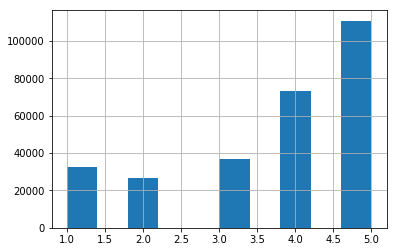

In [2]:
train = pd.read_csv('/home/adam/R/Yelp/dataset/model_train.csv', usecols = ['text', 'stars'])

train['stars'].hist();train.head()

So just as I saw during my exploration of the full set of reviews, this sample is quite skewed towards 4 and, especially, 5 star reviews. I don't think this is something I'd want to balance the data set for, but it's something I want to be aware of when I'm looking at model accuracy.

In terms of data prep, initially all I need to do is one-hot-encode my ratings variable. This will give me 5 binary columns, one for each rating level.

In [3]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
0,I'm always looking for tasty vegetarian restau...,0,0,0,1,0
1,Ribs were very dry and overlooked not fall of ...,0,1,0,0,0
2,Love the lunch specials - have tried the mac&c...,0,0,0,1,0
3,"I am not a meat person, so not too familiar wi...",1,0,0,0,0
4,Not sure what people are raving about. The lin...,0,0,1,0,0


In [4]:
test = pd.read_csv('/home/adam/R/Yelp/dataset/model_test.csv', usecols=['text', 'stars'])
test = pd.get_dummies(test, columns = ['stars'])
train.shape, test.shape

((280000, 6), (70000, 6))

So now I have a training set with 280,000 reviews and test set with 70,000. To make these models train super fast for exploration, I'm going to grab a sample and use that subsample in the initial trainings below. When I narrow it down to a final 'best' model, I'll retrain with the full data set to see what my accuracy becomes.

In [5]:
# set frac = 1. to use the entire sample
train_samp = train.sample(frac = 1.)
test_samp = test.sample(frac = 1.)
train_samp.shape, test_samp.shape

((280000, 6), (70000, 6))

## Naive Bayes Linear Model

First things first, I want to establish some sort of baseline model. Generally, a linear model is appropriate and has the advantage of being fast to train. One of the numerous things I've learned while taking [fastai's](http://course.fast.ai/) MOOC's is that a Naive Bayes linear classifier is a really solid baseline for NLP problems. Let's take a look and see how it works.

Naive Bayes uses Bayes theorem to calculate the conditional probability of a rating given some text. Of course, this is quite vague. Say my review is "This restaurant is terrible". I could take that 4 word sentence and see how often it appears in 1 star reviews and then see how often it appears in 5 star reviews. With those counts you could calculate a probability ratio telling you what type of review that text appears in more frequently.

But I'm sure you've noticed a problem. How many reviews have that *exact* text 'This restaurant is terrible'? We'd never get satisfying results because reviews would all have unique text. A simple way around this is to remove all the structure of the sentences and just use a bag of words representation of review text. "This restaurant is terrible" becomes a vector with counts of "This", "restaurant", "is", "terrible". For this baseline model I am just using unigrams, but bi/trigrams could easily be used as well (and could results in a modest accuracy bump). 

As one final preprocessing step, I'm actually going to use tfidf(term frequency, inverse-document frequency) rather than simple word counts to represent the word vectors. Essentially, this weights the words to show how important a word is to a particular review--so frequently used words, such as 'the', have a lower weight since they appear so often in almost every review.

This tokenizing and tfidf calcuation is all done with sklearn's TfidfVectorizer method.

In [28]:
# max_features is an upper bound on the number of words in the vocabulary
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

With the text in a usable form, I can now apply Bayes theorem. We want to answer the questions: given the review "This restaurant is terrible", what is the probability this is a 1 star review and what is the probability this is a 5 star review(this all works the same for 1-5 star reviews, it's just easier to illustrate with a binary classification). Well, another way of asking this question is: what is the probability of a one star review given the words "This", "restaurant", "is", "terrible"? If we assume each word is independent of the other (a very naive assumption--but where naive bayes gets it's name), then we can calculate this by:
$$\textit{P(this|1 star)} \times \textit{P(restaurant|1 star)} \times \textit{P(is|1 star)} \times \textit{P(terrible|1 star)}$$

One wrinkle is what do we do for words that we haven't seen in a review category. Do we pretend 'amazing' is never seen in a 1 star review just because we haven't seen it yet? This would cause a lot of issues, so we get around it by adding 1 to all word counts. This basically says--yeah, we haven't seen that word yet, but we acknowledge it's possible it might occur.

After all this, you can calculate the probability of a 'This restaurant is terrible' given a 1 star review and given a 5 star review. Once calculated, we just predicted the rating of whichever probability is highest--or we can divide them and predict 1 star if positive and 5 stars if negative. 

These predictions would be the result for a simple naive bayes model, but here I am actually going to use these
naive bayes calculations (or features) in a logistic regression model. I will take my naive bayes probability calculations and multiply them by my original feature matrix and then learn the parameters with a logistic regression model. For a better explanation than I can give, take a look at Jeremy Howard's explanation [here](https://youtu.be/37sFIak42Sc?t=3745).

I created a NBFeatures class to implement all the Naive Bayes logic.

In [30]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

And then I take advantage of sklearn Pipeline to cleanly combine several steps. This first takes the data and tokenizes and calculates tfidf (using the tfidfVectorizer created earlier). It feeds that into the NBFeatures method to generate all the Naive Bayes features. And finally those features are fed into the logistic regression where the parameters are learned.

In [31]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

The star ratings are predicted one at a time, so below I just enumerate through the binary ratings columns and generate probability predictions for each class. 

In [32]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train_samp[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]

CV score for class stars_1 is 0.9342857146539346
CV score for class stars_2 is 0.9028607154567014
CV score for class stars_3 is 0.8726642832748216
CV score for class stars_4 is 0.7535071476722662
CV score for class stars_5 is 0.8113142805181642


I am using 3 fold cross validation to estimate how accurate my predictions are. It should be noted that accuracy in this setting is not simply 'Was the rating for review X predicted correctly?'. That sort of accuracy isn't how sklearn or keras measure multiclass problems by default.  The CV score is measuring the accuracy of each individual rating as it's fit--so 'Did we predict the correct label for review X for rating 1 star?'. ~93% of the time we predicted the labels for stars_1 correctly, but that doesn't mean I was 93% accurate overall. 

I think a classification report is actually a better way to examine model accuracy for this sort of problem. When I look at the classification report for the model, I see that I'm able to pick out 1 and 5 star reviews pretty well, but 2-4 star reviews are missed a lot. These middling reviews could be considered more ambiguous.  This is a problem that is particular to this sort of data set and is one all our models will have to deal with. 1 and 5 star reviews tend to be very positive or very negative (think back to my initial analysis [here](https://www.ahoulette.com/2018/04/11/reviewing-yelp/) to see more details). This makes them relatively easy to classify. But what happens when you have a *pretty* good review? The characteristics of 3 and 4 star reviews are much more similar than those of 1 and 5 star reviews, so classifying them correctly is *going* to be more difficult. If you just look at a couple reviews you can see how difficult this can be for humans, let alone machines.

In [28]:
train['text'][0]

'I\'m always looking for tasty vegetarian restaurants in the Las Vegas area and the other day I saw that this place had a groupon. My girlfriend and I purchased the groupon and went in for lunch. I\'ve been to pretty much every vegetarian restaurant in the valley and I must say, this place was delicious. Much of the time I find that Asian vegetarian joints just have veggie meats and somehow that makes for a good meal, like the mediocre "Veggie Delight." But Veggie house seems to have out a lot of time into their menu and combination of flavors. We ordered the BBQ meat appetizer and the sauce was delicious. We had braised tofu and crispy eggplant for our Entrees and both were unique and flavorful. Both dishes had distinct flavors and had obviously been developed by someone who cares about flavor profiles. Our server was nice and accommodating and she made suggestions that were delicious. We will be dining here again and spreading the word about the flavors.'

That's a 4 star review. To me, that seems like a 5 star review as the only seemingly negative thing is a reference to a 'mediocre' menu item at another restaurant. This definitely isn't a trivial task for a human, so even the naive bayes level of performance is pretty impressive for a machine.

In [33]:
t = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

             precision    recall  f1-score   support

          0       0.68      0.76      0.72      8194
          1       0.49      0.30      0.37      6678
          2       0.51      0.35      0.42      9100
          3       0.52      0.49      0.51     18203
          4       0.70      0.85      0.77     27825

avg / total       0.61      0.63      0.61     70000



## Neural Network Model

But why stop with something like Naive Bayes. The world of NLP is being overrun with word2vec embeddings, neural network architectures and a whole host of novel techniques. Let's explore a couple of these newer ideas and see what sort of predictions we can come up with.

There are several frameworks to choose from when implementing neural networks in Python, but I'll be using tensorflow/keras for this problem. There are some super impressive results being churned out by the folks at [fastai](http://course.fast.ai/) using pytorch and the cutting edge techniques they implement in the fastai library, but I'll use keras for now since I haven't used it before and it's very commonly used.

### Embeddings and Tokens

The first big development in NLP that I want to look at are embeddings or word vectors. The basic Word2Vec technique attempts to represent a words meaning by counting the context in which a word appears. Since we are dealing with natural language, this would be many thousands of different contexts, resulting in vectors with potentially millions of dimensions. As an example, you could see 'it' appear contextually as 'it was', 'it wasn't', 'it became', and 'it sat' just to name a few. Since it *doesn't* appear in thousands of other contexts, what we'd end up getting is a long vector  of \[0, 1, 0, 0, 0, 0, 2, 0, ...] where there is a 0 in contexts where that word wasn't seen and a count with the number of times that word appeared in the other spots. 

It turns out that you can represent most of this information (or vector space) with far fewer dimensions so word vectors use dimensionality reduction techniques to reduces the number of dimensions down to, say, 25-300. For a more detailed overview of the basic idea, this [gist](https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469) is a good code focused walk through.

This might not, initially, seem all that useful, but what these word vectors do is tell us the relationship between words. Since they are vectors, we can perform arithmetic with them. The canonical example goes something like this: what do you get if you take ***queen*** and subtract ***woman***? A ***king***. Or what about if you add ***frozen*** to ***water***? You get ***ice***!  There is something really cool about this to me and I'd encourage you to explore the concept yourself to learn more.

The bad news is that training your own word vectors requires an enormous amount of text data. Luckily, there are several very good precomputed vectors(or embeddings) which are freely distributed and available for modeling. Here I'll be using [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings taken from the twitter corpus. There are GloVe embeddings from other sources, such as Wikipedia or the common crawl, as well as other embeddings like FastText. Since I know from exploration that reviews often contain non-standard english and unusual punctuation/language I thought twitter seemed fitting. It performed the best out of the embeddings I tried, but depending on your data set another embedding may perform better. If you want to get really fancy you can combine embeddings--that seems to be very common and very powerful if Kaggle competitions are any indication.

My twitter embeddings are 200 dimensional, so I need to set my embedding size equal to that number of dimensions. This will be used to build my embedding matrix.

In [6]:
# I'm using GLoVe word vectors to get pretrained word embeddings
embed_size = 200 
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = '/home/adam/R/Yelp/dataset/glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [7]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
# Splitting off my y variable
y = train_samp[class_names].values

Now I need to tokenize my data. Just like above with Naive Bayes, I'm using the defaults and splitting into individual words, but here I have to take the additional step of padding the vectors so that they are all equal length. Keras requires this, and it's easy to do with their pad_sequences method.

In [8]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [9]:
import pickle

with open('keras_tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

Now I need to read in my embeddings. One issue that can come up when using pretrained embeddings is that if a word didn't appear in the embedding training data set, then there is no vector for it in the embedding file. You can randomly initialize vectors for words that don't appear in your embedding vector or you could use multiple embedding files(like glove + fasttext) to attempt to cover a larger vocabulary. Here I'm actually going to just leave them as zero vectors because I'm only using the twitter embeddings as a starting point and I will allow tuning of them while building the model. This resulted in the best model in my specific case, but you should try out several methods and see what works best for a new data set.

In [9]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

Out of curiosity I appended all the words that weren't present in the twitter embeddings to a list so I could examine them. A lot of the words seem pretty specific to restaurant reviews. There are many restaurant names, food names and words that just probably don't appear that often in tweets.  One area where I could definitely squeeze out some more accuracy is by fixing all the contractions that are missing from the embedding vocabulary. I could take this even further and stem and lemmatize the tokens and probably improve accuracy even more.  Ultimately, since I am not competing and really trying to eek out thousandths of a decimal point improvement, I'll leave it as is. Just keep in mind there is lots of room for improvement to be had by playing around with this embedding matrix and messing around with word engineering.

In [63]:
len(missed)

1955

In [40]:
missed[0:10]

["it's", "don't", "i'm", "i've", "didn't", '2', '5', '3', "wasn't", "can't"]

In [64]:
missed[1000:1010]

['heartier',
 'omnivores',
 'weera',
 "monty's",
 "cannoli's",
 "vito's",
 "'ok'",
 'diavola',
 "millie's",
 'porkbelly']

### Modeling

#### Specify Model

One thing I found after doing a *ton* of research and looking at many, many, many Kaggle competitions is that the specs of the neural network itself are often less important than other components of the model pipeline. In this case, I tried combinations of LSTM(long short-term memory) layers, GRU(gated recurrent units) layers, adding multiple dense layers, stacking multiple GRU or LSTM layers, bidirectional vs standard layers, etc and all had pretty similar levels of performance. I ended up going with an architecture that was successfully applied in the Kaggle Toxic Comment Classification [competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644). I used that structure as my baseline and nothing I tried beat it by much. I did have a double GRU followed by a huge dense layer structure that performed marginally better, but took quite a bit longer to train so I abandoned it.

I won't go into much detail about LSTM vs GRU because, frankly, I'm not an expert and I learned most of what I know from several [*excellent*](http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/) [blog](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) [posts](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 

Just a couple implementation notes: I set trainable to true even though I am using pretrained embeddings. This resulted in a higher accuracy. This is probably related to fine tuning the vectors and training vectors for the numerous words that didn't appear in the glove twitter embeddings. I also set up earlystop and checkpoint callbacks. Early stop will automatically stop training the model after your desired metric is no longer improving. This was really handy because I could just set the number of epochs to a relatively high number and let keras automatically stop when overfitting is likely occurring. Thanks to checkpoint, the weights from the best epoch are saved.

In [10]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#### Fit Model

Here, I finally fit the model. I use a small validation set of about 28,000 reviews to evaluate model accuracy as I'm training. 

In [11]:
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Train on 12600 samples, validate on 1400 samples
Epoch 1/20
12600/12600 [==============================] - 22s 2ms/step - loss: 0.5521 - acc: 0.7294 - val_loss: 0.4718 - val_acc: 0.8000
Epoch 2/20
12600/12600 [==============================] - 19s 2ms/step - loss: 0.4591 - acc: 0.8010 - val_loss: 0.4471 - val_acc: 0.8077
Epoch 3/20
12600/12600 [==============================] - 19s 1ms/step - loss: 0.4435 - acc: 0.8116 - val_loss: 0.4213 - val_acc: 0.8287
Epoch 4/20
12600/12600 [==============================] - 19s 2ms/step - loss: 0.4149 - acc: 0.8224 - val_loss: 0.3836 - val_acc: 0.8304
Epoch 5/20
12600/12600 [==============================] - 20s 2ms/step - loss: 0.3838 - acc: 0.8309 - val_loss: 0.3572 - val_acc: 0.8404
Epoch 6/20
12600/12600 [==============================] - 19s 2ms/step - loss: 0.3679 - acc: 0.8346 - val_loss: 0.3439 - val_acc: 0.8416
Epoch 7/20
12600/12600 [==============================] - 19s 2ms/step - loss: 0.3484 - acc: 0.8424 - val_loss: 0.3373 - val_acc:

#### Model Evaluation

In [14]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)

70000/70000 [==============================] - 18s 255us/step


In [25]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

70000/70000 [==============================] - 17s 249us/step


[0.26221254204341343, 0.8771714176586696]

In [20]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

             precision    recall  f1-score   support

          0       0.79      0.72      0.75      8194
          1       0.51      0.58      0.54      6678
          2       0.59      0.50      0.54      9100
          3       0.60      0.57      0.59     18203
          4       0.78      0.83      0.81     27825

avg / total       0.68      0.69      0.68     70000



Our model is by no means perfect, but the neural network approach improved precision and recall by about 10% each. That's pretty substantial. Perhaps most significantly, 2-4 star reviews saw the biggest improvement and those were particularly weak areas for the naive bayes model. Our accuracy also improved about 2.5% and is up to nearly 88% now. This should be plenty accurate for my web application.

#### Saving Model

Since the neural network takes a decent amount of time to train, saving the model is essential. Normally I'd save models as a pickle file, but the Keras documentation doesn't recommend that. Luckily, Keras provides a pretty easy scheme to save both model weights and model architecture. 

In [13]:
model.save('yelp_nn_model.h5')

#### Improving the model

There's tons of room for improvement here. Some of the low hanging fruit would be:

* ***Specifying better embeddings*** Combining glove and fasttext embeddings to get better coverage would be a good start, but there's plenty of other tweaks to do here. I could encode seemingly important text features--such as overuse of capital letters. I could even get really ambitious and normalize text by fixing things like spelling errors. I think is probably the single largest area for improvement.

* ***Train/Test-time augmentation(TTA)*** This is something I heard about on Kaggle and really wanted to try, but I didn't have time. The basic idea is to use machine translation to translate the reviews to, say, French and then back to English. This will alter the text of the review effectively giving you more data. This should be useful in reducing overfitting and allowing you to train a better model. Additionally, the machine translation will often take care of simple text correction which is helpful for accuracy. This technique was applied very successfully in some recent Kaggle classification competitions.

* ***Ensembling models together*** It's a huge simplification, but the best model is often a combination of several models.  A starting point would be combining the Naive Bayes and LSTM/GRU models through simple averaging. You can expand this a huge amount, but I'd have to set up a very rigorous cross validation scheme to avoid massively overfitting.

* ***Using newer architectures*** Recently, capsule networks and special types of convolutional neural networks--typical used on image classification--have been shown to be highly effective in NLP problems. These models are high performing on their own, but since they are significantly different architectures from the RNN's I've used above, they are also promising candidates for ensembling.

But, again, this isn't about building the best possible model. I just want a 'good' model that I can use in my simple application. I'd encourage those interested to try some of the improvements listed above and share the results!

## What is this model good for?

After a lot of fiddling and a decent amount of frustration, I have a functional, decently accurate model. At the end of the day though, what you really care about in practice is 'what business problem is this model helping to solve?'. While in a professional data science environment the identification of the business problem comes first, since this is a toy project, the pipeline is a little off kilter. But that doesn't mean I can't do a little thought experiment and examine how this model could be useful in practice. 

* An obvious application of this model would be to help eliminate mislabeled reviews(example below). While exploring the data, it was obvious that some reviews labeled 1 star were actually positive reviews and vice versa for 5 star reviews.  People certainly misclick reviews and this is bad. If people go to a restaurant labeled 5 stars on Yelp and have a 1 star experience, then the trust they put into future reviews goes down. Maybe that means they don't go to Yelp for reviews as often. That's bad for business. But with this model, you could read the text of the review and say 'Oh, this seems like a 4 star review. You labeled it 1 star. Is that correct?' Alleviating mislabeled reviews could be quite helpful for Yelp.

In [61]:
# this review was predicted as a 5 star but actually was a 1 star review
test_samp['text'][367]

'First time at this restaurant and my husband and I had an excellent meal.  My husband ordered the fish and chips that is served with tarter sauce.  Our server, Sean, went above and beyond and even made us cocktail sauce from scratch (his personal recipe which was delicious). Great food and excellent service.  Thank you Sean for treating us like family.'

* Another potential use would be identifying really negative reviews before they are posted and adding some sort of 'intervention check'. What do I mean by this? Well, really awful Yelp reviews can be extremely damaging to a restaurant--especially if it is new. And often when someone has a bad experience at a restaurant, they want to vent and completely nitpick and destroy that restaurant to feel better. Bad reviews are an important component of the site, but what if when a really bad/toxic review was detected (one with a very high probability score for 1 star), you saw an additional page before confirming your post. Who knows what the wording would be, but something just reminding you that that restaurant is owned by *people* and to take a breath before posting a damning review.  This would have to be highly tested, but it could be a component of making reviews less of a potentially toxic environment.

Perhaps a better business focused model would be one just identifying the positive/negative reviews or one identifying 'toxic' reviews whether good or bad. Identifying toxic reviews would require a labeled data set for toxic comments though, and identifying positive/negative reviews was something I looked at initially, but I wanted more of a challenge :) 

I had a lot of fun building this model and I definitely learned a lot about implementing high performing neural networks. In the future I'd like to replicate this using Pytorch and fastai. The team (and students) at fastai have been doing amazing work breaking state of the art barriers on a bunch of tasks, so I'd love to see what I could do with that as a backbone.

For now though, this gives me a good model to use for my application. Up next, I'll be building a simple web app using Dash and Python. See you next time.

##### Acknowledgements

I leaned heavily on the work of others for this post and I'd be remiss if I didn't acknowledge and thank them for their great work.

* Alexander Burmistrov-[Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644)
* SM - [Kaggle](https://www.kaggle.com/sermakarevich/sklearn-pipelines-tutorial/notebook)